In [1]:
import numpy as np
import os
import shutil
from glob import glob
from tqdm import tqdm
from cv2 import imread, resize

import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Lambda, Dense, Flatten
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.utils import plot_model

In [2]:
n_classes = 28
train_size = 0.6
class_size = 20
seed = 47
input_shape = (100, 100, 1)
w, h, c = input_shape

In [3]:
def load_data(path):

    X = []
    for char in range(1, 29):
        
        class_list = []
        files = glob(os.path.join(path, str(char))+'/*.png')
        np.random.seed(seed=seed)
        files = np.random.choice(files, size=class_size, replace=False)
        for f in files[:class_size]:

            img = imread(f, 0)
            class_list.append(resize(img, (w,h)))

        X.append(np.array(class_list))
    X = np.array(X)[..., None] / 255.0
    
    return X

In [4]:
data = load_data('/content/drive/My Drive/dataset')

In [5]:
def get_batch(batch_size=64):

    targets = np.zeros(batch_size)
    targets[batch_size//2:] = 1
    np.random.shuffle(targets)

    pairs = [np.zeros((batch_size, w, h, c)) for i in range(2)]

    train_classes = int(train_size*n_classes)
    class_one = np.random.choice(train_classes, size=batch_size, replace=False)
    idx1 = np.random.randint(0, class_size, batch_size)
    idx2 = np.random.randint(0, class_size, batch_size)

    for i in range(batch_size):

        pairs[0][i] = data[class_one[i], idx1[i]]
        
        class_two = None
        if targets[i] == 1:
            class_two = class_one[i]
        else:
            class_two = (class_one[i] + np.random.randint(1, train_classes)) % train_classes
            assert class_two != class_one[i], "Error, same class"

        pairs[1][i] = data[class_two, idx2[i]]
        
    return pairs, targets

In [6]:
def model():
    
    W_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.01)
    FC_W_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.2)
    b_init = keras.initializers.RandomNormal(mean = 0.5, stddev = 0.01)
    
    input_img1 = Input(input_shape)
    input_img2 = Input(input_shape)

    model = Sequential()
    model.add(Conv2D(64, (10, 10), activation='relu', input_shape=input_shape,
                    kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())

    model.add(Conv2D(128, (7, 7), activation='relu',
                    kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())

    model.add(Conv2D(128, (4,4), activation='relu',
                    kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(256, (4,4), activation='relu',
                    kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    
    model.add(Dense(4096, activation='sigmoid',
                   kernel_initializer=FC_W_init, bias_initializer=b_init, kernel_regularizer=l2(1e-3)))
    
    encoding1 = model(input_img1)
    encoding2 = model(input_img2)

    distance = Lambda(lambda embed: K.abs(embed[0] - embed[1])) ([encoding1, encoding2])
    prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(distance)

    siamese_net = Model(inputs=[input_img1, input_img2], outputs=prediction)

    return siamese_net

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         27413312    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4096)         0           sequential[0][0]      

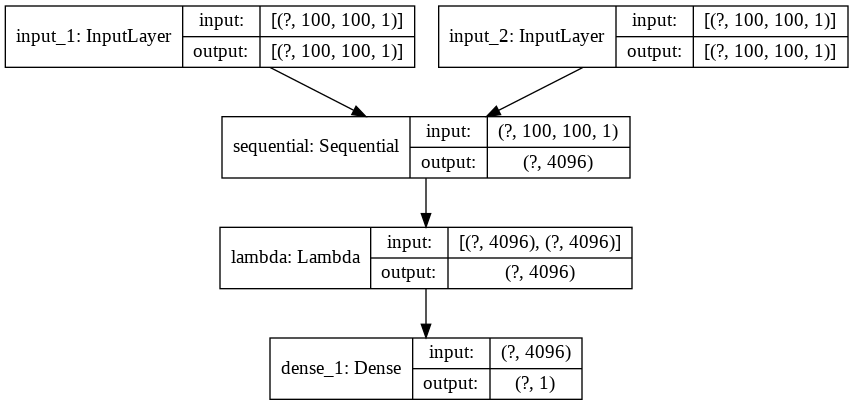

In [7]:
siamese_net = model()
optimizer= Adam(learning_rate=0.0006)
siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer)

siamese_net.summary()
plot_model(siamese_net, show_shapes=True, show_layer_names=True)

In [ ]:
def nway_one_shot(n_way, split='val'):

    train_classes = int(train_size*n_classes)
    val_classes = [x for x in range(train_classes, n_classes)] if split == 'val' else [x for x in range(0, train_classes)]

    classes = np.random.choice(val_classes, size=n_way, replace=False)
    pairs = [np.zeros((n_way, w, h, c)) for k in range(2)]
    true_class = classes[0]
    indices = np.random.randint(0, class_size, size=n_way)
    idx1, idx2 = np.random.choice(class_size, size=2, replace=False)

    for k in range(n_way):
        
        pairs[0][k] = data[true_class][idx1]

        if k == 0:
            pairs[1][k] = data[true_class][idx2]
        else:
            pairs[1][k] = data[classes[k]][indices[k]]

    return pairs        

def one_shot_task(n_val, n_way, split='val'):

    n_correct = 0
    for i in range(n_val):

        pairs = nway_one_shot(n_way, split)
        probs = siamese_net.predict(pairs)
        if np.argmax(probs) == 0:
            n_correct += 1
        
    accuracy = 100 * n_correct / n_val
    # print(f'Accuracy = {accuracy}')
    return accuracy


In [9]:
epochs = 200*1000
every = 7000
batch_size = 16
n_val = 200
n_way = 12
best = 80
model_path = '/content/drive/My Drive/Colab Notebooks'

In [ ]:
for i in range(epochs):

    pairs, targets = get_batch(batch_size=batch_size)
    loss = siamese_net.train_on_batch(pairs, targets)
    if i % every == 0:
        print("\n ------------- \n")
        print("Train Loss: {0}".format(loss)) 
        val_acc = one_shot_task(n_val, n_way)
        if val_acc >= best:
            siamese_net.save_weights(os.path.join(model_path, f'weights.{seed}.{i}.h5'))
            print(f'\nCurrent best: {val_acc}, previous best: {best}')
            best = val_acc

In [16]:
def nn_model(nway):

    pairs = nway_one_shot(nway)
    distance = np.zeros(nway)
    for i in range(nway):

        distance[i] = np.sum((pairs[0][i] - pairs[1][i])**2)
    
    return np.argmin(distance) == 0

def test_nn(trials, nway):

    correct = 0
    for i in range(trials):
        correct += nn_model(nway)

    return 100 * correct / trials

# Testing

In [56]:
siamese_net.load_weights('/content/drive/My Drive/Colab Notebooks/weights.47.14000.h5')

In [ ]:
train_acc, val_acc, nn_acc = [], [], []
trials = 500
ways = [x for x in range(2, 13)]

for nway in tqdm(ways):

    train_acc.append(one_shot_task(trials, nway, split='train'))
    val_acc.append(one_shot_task(trials, nway, split='val'))
    nn_acc.append(test_nn(trials, nway))

In [58]:
train_acc

[99.8, 99.6, 99.0, 98.6, 98.8, 97.4, 97.2, 96.8, 96.6, 97.0, 96.0]

In [59]:
val_acc

[97.8, 97.2, 98.2, 98.4, 96.6, 95.4, 95.0, 95.6, 94.0, 96.0, 92.8]

In [60]:
nn_acc

[57.8, 45.8, 37.4, 31.4, 31.0, 26.2, 23.2, 19.8, 19.6, 22.8, 15.2]

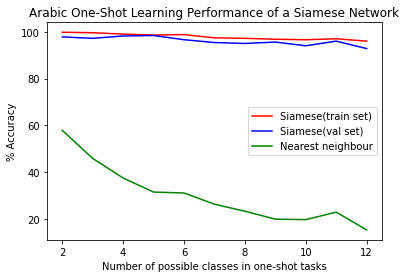

In [72]:
import matplotlib. pyplot as plt
fig,ax = plt.subplots(1)
ax.plot(ways, train_acc, "r", label="Siamese(train set)")
ax.plot(ways, val_acc, "b", label="Siamese(val set)")
plt.plot(ways, nn_acc, "g", label="Nearest neighbour")

plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Arabic One-Shot Learning Performance of a Siamese Network")
ax.legend()
plt.show()